# Building and Exploring the Knowledge Graph

To be able to run this code effectively, you must have neo4j desktop installed on your device.
You will also need to have a Local DMBS called DiagnosesTesting with password "diagtest" running and open.

In [1]:
# Libraries
import pandas as pd
from py2neo import Graph, Node, Relationship
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Paths
path = 'MergedData.csv'

In [3]:
# First draft Erika
# Load data from the csv file
df = pd.read_csv(path)

# The POC focuses on these main diagnoses
diagnoses = ['asthma', 'irondef', 'pneum', 'substancedependence', 'fibrosisandother', 'malnutrition']

In [4]:
# First draft Erika
# Create a directed graph using NetworkX
G = nx.DiGraph()

In [5]:
# First draft Erika
# Add nodes and edges for attributes
for index, row in df.iterrows():
    eid = row['eid']
    G.add_node(eid, gender=row['gender'], rcount=row['rcount'],
               hematocrit=row['hematocrit'], neutrophils=row['neutrophils'],
               sodium=row['sodium'], glucose=row['glucose'],
               bloodureanitro=row['bloodureanitro'], creatinine=row['creatinine'],
               bmi=row['bmi'], pulse=row['pulse'],docnote=row['Doc Note'])

    # Add nodes and edges for conditions
    diagnoses = ['asthma', 'irondef', 'pneum', 'substancedependence', 'fibrosisandother', 'malnutrition']
    
    for diagnosis in diagnoses:
        if row[diagnosis] == 1:
            G.add_node(diagnosis)
            G.add_edge(eid, diagnosis)

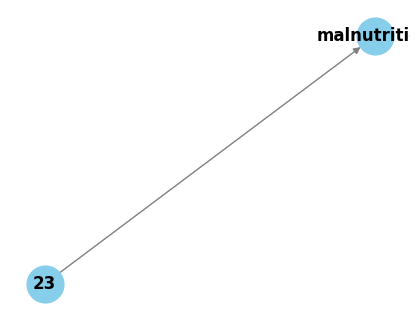

Patient 23 Attributes:
gender: M
rcount: 3
hematocrit: 13.2
neutrophils: 6.3
sodium: 137.3711519
glucose: 147.0920035
bloodureanitro: 28.0
creatinine: 1.065005463
bmi: 28.34169288
pulse: 70
docnote: 10. Malnutrition requiring tube feedings. 11. Depression. DISCHARGE DISPOSITION: _%#NAME#%_ _%#NAME#%_ will be going over to Fairview University Transitional Care Center for ongoing rehabilitation. DISCHARGE MEDICATIONS:. 1. Dilantin suspension 400 mg down feeding tube b.i.d. 2. Dulcolax suppository 10 mg PR q day. 3. Digoxin 250 mcg down feeding tube q day. 4. Lasix 20 mg down feeding every other day. 5. Lantus insulin 45 units subcu q h.s. 6. Regular insulin sliding scale with q.i.d. Accu-Cheks.


In [6]:
# First draft Erika
patient_num = 23

# Create a subgraph containing nodes and edges connected to the specified patient
subset_nodes = list(G.neighbors(patient_num)) + [patient_num]
subset_edges = list(G.edges(patient_num))

subset_graph = G.subgraph(subset_nodes + subset_edges)

# Visualize the subgraph with node attributes
pos = nx.spring_layout(subset_graph)

# Extract the attributes of the specified node
node_attributes = subset_graph.nodes[patient_num]

# Draw the graph
plt.figure(figsize=(4, 3))
nx.draw(subset_graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', edge_color='gray')
plt.show()

# Print the node attributes
print(f"Patient {patient_num} Attributes:")
for attribute, value in node_attributes.items():
    print(f"{attribute}: {value}")

In [7]:
# First draft Erika
# Connect to Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "diagtest"))

# Clear any existing graph (delete all nodes and relationships)
graph.run("MATCH (n) DETACH DELETE n")

# Add nodes and edges for attributes
for index, row in df.iterrows():
    Patient_ID = row['eid']
    
    # Create or update the patient node with attributes
    patient_node = Node("Patient", Patient_ID=row['eid'], Gender=row['gender'], Readmissions_last_180_days=row['rcount'],
                       Hematocrit=row['hematocrit'], Nutrophils=row['neutrophils'],
                       Sodium=row['sodium'], Glucose=row['glucose'],
                       Blood_Urea_Nitrogen=row['bloodureanitro'], Creatinine=row['creatinine'],
                       BMI=row['bmi'], Pulse=row['pulse'], Respiration=row['respiration'], Doc_Note=row['Doc Note'])
    graph.merge(patient_node, "Patient", "Patient_ID")

    # Defining the nodes for the conditons
    conditions = ['asthma', 'irondef', 'pneum', 'fibrosisandother', 'malnutrition']

    # Creating the relationships between the patients and the diagnoses
    for condition in conditions:
        if row[condition] == 1:
            condition_node = Node("Condition", name=condition)
            graph.merge(condition_node, "Condition", "name")

            relationship = Relationship(patient_node, "HAS_CONDITION", condition_node)
            graph.create(relationship)

### Run the below in neo4j desktop to view the first 250 pati nts (you can change this from the limit 250 l
iMATCH (p:Patient)-[r:HAS_CONDITION]->(c:Condition)
WITH p, r, c
ORDER BY p.Patient_ID
LIMIT 300
RETURN p, r, c;e, r, c;